In [1]:
from css_utility import *

/home/lee/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [26]:
def merge_intervals(df_list):
    merged_list = []  # List to hold merged DataFrames

    for df in df_list:
        # Sort by 'TxStart'
        df = df.sort_values(by='TxStart')

        # Initialize an empty list to store the merged intervals
        merged = []

        # Iterate through the rows in the DataFrame
        for _, row in df.iterrows():
            # If the list of merged intervals is empty, or the current interval does not overlap with the previous one,
            # append it to the list
            if not merged or merged[-1]['TxEnd'] < row['TxStart']:
                merged.append({'TxStart': row['TxStart'], 'TxEnd': row['TxEnd']})  # Only keep 'TxStart' and 'TxEnd'
            else:
                # Otherwise, there is an overlap, so we merge the current and previous intervals
                merged[-1]['TxEnd'] = max(merged[-1]['TxEnd'], row['TxEnd'])

        # Convert the merged intervals back into a DataFrame and append it to the list
        merged_list.append(pd.DataFrame(merged))

    return merged_list


In [27]:
raw_gene_table=whGene2GLChr(whole_gene_file)  # list of df

Extracting the gene file ...
Done!


In [28]:
merged_list=merge_intervals(raw_gene_table)

In [34]:
whole_gene_file

'../database/RefSeq/RefSeq.WholeGene.bed'

In [35]:
with open("../database/roadmap/df_pickled/E001_df_pickled.pkl", "rb") as f:
    df=pickle.load(f)

In [36]:
df

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
510145,chrY,59003800,59005800,15,2000,10,O,OOOOOOOOOO
510146,chrY,59005800,59006000,9,200,1,I,I
510147,chrY,59006000,59011800,15,5800,29,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOO
510148,chrY,59011800,59026000,9,14200,71,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [37]:
def compNonGene2css_fixing(whole_gene_file,df):
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at "non-genic" area only.
    """
    
    print("Extracting the CSS on the intergenic region ...")

    ########### new fancy gene table without overlap ###########
#     new_gene_lst_all=gene_removeDupl(whole_gene_file)
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    new_gene_lst_all=merge_intervals(g_df_chr_lst)
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(new_gene_lst_all)
    
    css_Ngene_lst_all=[]
        
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=new_gene_lst_all[i] # gene df of i-th chromosome
        
        assert gene_df["TxStart"].iloc[0]>=1, "Gene starts from the very first location at {}-th chromosome.".format(i)
        assert gene_df["TxEnd"].iloc[-1]<=len(css), "Gene ends at the very last location at {}-th chromosome.".format(i)  
                
        css_Ngene_lst_chr=[]        
        for j in range(len(gene_df)):
            if j==0:
                ng_start=1 # to avoid any "zero" causing problem 
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            elif j==len(gene_df)-1: 
                ng_start=gene_df["TxEnd"].iloc[j]
                ng_end=len(css)
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking
            else:
                ng_start=gene_df["TxEnd"].iloc[j-1]
                ng_end=gene_df["TxStart"].iloc[j]
#                 print("j: {} | ng_start: {} - ng_end: {} ".format(j, ng_start, ng_end)) # for checking 
        
            css_Ngene=css[ng_start:ng_end]
            css_Ngene_lst_chr.append(css_Ngene)
        
        css_Ngene_lst_all.append(css_Ngene_lst_chr) 
        
    assert len(css_Ngene_lst_all)==total_chr
    print("Done!")
    
    return css_Ngene_lst_all

In [38]:
css_Ngene_lst_all=compNonGene2css_fixing(whole_gene_file,df)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [40]:
type(css_Ngene_lst_all[0])

list

In [ ]:
len(css_Ngene_lst_all)

In [42]:
len(css_Ngene_lst_all[3])

832

In [43]:
Ngene_css_len_all=[len(item) for item in css_Ngene_lst_all[0]]

<Axes: ylabel='Count'>

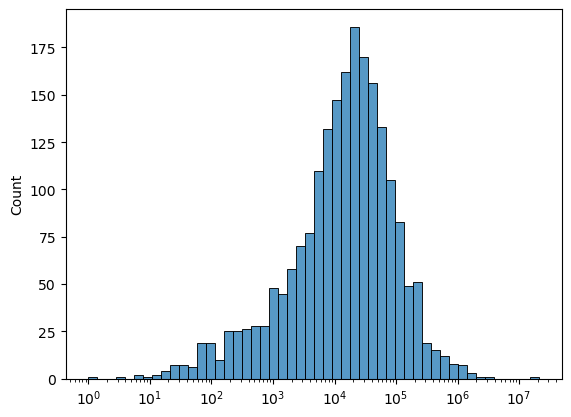

In [51]:
sns.histplot(Ngene_css_len_all, bins=50, log_scale=True)

In [52]:
def compGene2css_fixing(whole_gene_file,df):   # note that the result is also overlapped css... 
    """
    Input: Reference gene file, df (CSS)
    Output: list of chromosome-wise list that contains the css at genic area only.
    """
#     g_lst_chr=whGene2GLChr(whole_gene_file) # list of gene table df per chromosome
    
    ########### new fancy gene table without overlap ###########
#     g_lst_chr=gene_removeDupl(whole_gene_file) # should be further fixed
    g_df_chr_lst=whGene2GLChr(whole_gene_file)
    g_lst_chr=merge_intervals(g_df_chr_lst)
    ############################################################
    
    css_lst_chr=df2longcss(df) # list of long css per chromosome
    total_chr=len(g_lst_chr)
    
    css_gene_lst_all=[]
    for i in tqdm_notebook(range(total_chr)):
        css=css_lst_chr[i]   # long css of i-th chromosome
        gene_df=g_lst_chr[i] # gene df of i-th chromosome
        
        css_gene_lst_chr=[]
        for j in range(len(gene_df)):
            g_start=gene_df["TxStart"].iloc[j]-1  # python counts form 0
            g_end=gene_df["TxEnd"].iloc[j]+1      # python excludes the end
            
            css_gene=css[g_start:g_end]           # cut the gene area only
            css_gene_lst_chr.append(css_gene)     # store in the list
          
        css_gene_lst_all.append(css_gene_lst_chr)  # list of list
    
    assert len(css_gene_lst_all)==total_chr
    return css_gene_lst_all

In [53]:
css_gene_lst_all=compGene2css_fixing(whole_gene_file,df)

Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

In [78]:
len(css_gene_lst_all)

24

In [175]:
def long2unitCSS(long_css_lst, unit=200):
    let_str_lst_all=[]
    unit_cnt_lst_all=[]
    for elm in long_css_lst:
        unit_str=''
        unit_cnt_lst=[]
        unit_cnt=0
        for i, let_str in enumerate(elm):
            if i==0:     # handling the first letter
                unit_str+=let_str
                unit_cnt=1
            elif let_str==elm[i-1]: # handling the same letter
                unit_cnt+=1
            elif let_str!=elm[i-1]: # handling a different letter
                unit_str+=let_str
                unit_cnt_lst.append(int(unit_cnt/unit) if unit_cnt >= unit else 0)
                unit_cnt=1
        unit_cnt_lst.append(int(unit_cnt/unit) if unit_cnt >= unit else 0)  # handle the final letter
        let_str_lst_all.append(unit_str)
        unit_cnt_lst_all.append(unit_cnt_lst)
    return let_str_lst_all, unit_cnt_lst_all

In [229]:
def Convert2unitCSS_main_fixing(css_lst_all, unit=200): # should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    print("Converting css from the raw length into unit-length ... ")
    css_unit_lst_all=[]
    for chr_no in tqdm_notebook(range(len(css_lst_all))):
        css_chr_lst=css_lst_all[chr_no]
        css_chr_unit_lst=[]
        let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_chr_lst, unit=unit)
        unit_css_lst=['']*len(let_str_lst_all)
        for i, let_str in enumerate(let_str_lst_all):
            for j in range(len(let_str)):   ###fixed 29. June. 2023, not yet good to go
#             for j in range(len(let_str)): ###fixed 29. June. 2023
                unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
        unit_css_lst=[css for css in unit_css_lst if css!='']  # remove the empty element
        css_unit_lst_all.append(unit_css_lst)
    print("Done!")
    return css_unit_lst_all

In [204]:
def Convert2unitCSS_main_myfix(css_lst_all, unit=200): # should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    print("Converting css from the raw length into unit-length ... ")
    css_unit_lst_all=[]
    for chr_no in tqdm_notebook(range(len(css_lst_all))):
        css_chr_lst=css_lst_all[chr_no]
        css_chr_unit_lst=[]
        let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_chr_lst, unit=unit)
        
        if len(let_str_lst_all)==len(unit_cnt_lst_all)

#             unit_css_lst=['']*len(let_str_lst_all)
            unit_css_lst=''
            for i, let_str in enumerate(let_str_lst_all):
                

                for j in range(len(let_str)):   ###fixed 29. June. 2023
                    
                    unit_css+=let_str[j]*unit_cnt_lst_all[i][j]

#                     unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
            css_chr_unit_lst.append(unit_css)
    
        unit_css_lst=[css for css in unit_css_lst if css!='']  # remove the empty element
        css_unit_lst_all.append(unit_css_lst)
    print("Done!")
    return css_unit_lst_all

In [200]:
len()

3

In [218]:
a=['OIO', 'O','ABODA']
b=[[49, 4, 6], [4], [40,10,30,20,5]]

In [226]:

for i, let in enumerate(a):
    print(i, let)
    c_all=''
    for j in range(len(let)):
        c=let[j]*b[i][j]
        c_all+=c
    print(c_all)

0 OIO
OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOO
1 O
OOOO
2 ABODA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABBBBBBBBBBOOOOOOOOOOOOOOOOOOOOOOOOOOOOOODDDDDDDDDDDDDDDDDDDDAAAAA


In [ ]:
test_long_two=css_Ngene_lst_all[:2]

In [ ]:
css_unit_lst_all=Convert2unitCSS_main_myfixyfix(test_long_two, unit=200)

2

In [227]:
test_long_css=css_Ngene_lst_all

In [230]:
css_unit_lst_all=Convert2unitCSS_main_fixing(test_long_css, unit=200)

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [232]:
with open("../database/sandbox/test1_Ngene_css_unit.pkl","wb") as Ngene:
    pickle.dump(css_unit_lst_all,Ngene)

In [233]:
with open("../database/sandbox/test1_Ngene_css_unit.pkl","rb") as Ngene:
    test1=pickle.load(Ngene)

In [234]:
test1[0][0]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOO'

In [231]:
css_unit_lst_all[0]

['OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOO',
 'OOOO',
 'OOOOOOOOOOOOOOOOOOOO',
 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO',
 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO',
 'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [185]:
css_Ngene_unit_lst_all=Convert2unitCSS_main_fixing(css_Ngene_lst_all, unit=200)
with open("../database/sandbox/fixing_Ngene_css_unit.pkl","wb") as Ngene:
    pickle.dump(css_Ngene_unit_lst_all,Ngene)

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [186]:
with open("../database/sandbox/test_Ngene_css_unit.pkl","rb") as t:
    data=pickle.load(t)

In [187]:
data[0][0]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIII'

In [80]:
t_css_unit_lst_all=Convert2unitCSS_main_fixing(css_gene_lst_all, unit=200)

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [ ]:
test2_css_gene_unit_lst_all=Convert2unitCSS_main_fixing(css_gene_lst_all, unit=200)
with open("../database/sandbox/test2_gene_css_unit.pkl","wb") as f:
    pickle.dump(css_gene_lst_all,f)

In [81]:
len(t_css_unit_lst_all[0])

1688

In [94]:
t_css_unit_lst_all[0][100]

'EEEEEEEEEEEEEEEEEEEEEEEDDDDEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGGGGEEGGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEDDDEEEEEEEEEEDDDDDDDDFEEEEEEEEEEEEEEEBBBBBBBAJJJJJJJJJJJJAAEEEEEEEEEEEEEEEEEEEEEEGGOOOOOOOOOOOO'

In [96]:
css_gene_lst_all[0][100:102]

['AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ',
 'JJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJJ

In [97]:
long2unitCSS(css_gene_lst_all[0][100:102], unit=200)

(['AJ', 'JKLJKLGOEDEDEDEDEABA'],
 [[4, 0], [4, 1, 7, 5, 1, 2, 1, 51, 16, 7, 9, 6, 14, 4, 7, 3, 3, 1, 3, 4]])

In [54]:
len(css_gene_lst_all[3])

832

In [57]:
with open("../database/sandbox/test_gene_css.pkl","wb") as gene:
    pickle.dump(css_gene_lst_all,gene)

In [58]:
with open("../database/sandbox/test_Ngene_css.pkl","wb") as Ngene:
    pickle.dump(css_Ngene_lst_all,Ngene)

In [98]:
css_gene_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)
with open("../database/sandbox/test_gene_css_unit.pkl","wb") as f:
    pickle.dump(css_gene_unit_lst_all,f)

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [143]:
def Convert2unitCSS_main_test(css_lst_all, unit=200): # should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    print("Converting css from the raw length into unit-length ... ")
    css_unit_lst_all=[]
    for chr_no in tqdm_notebook(range(len(css_lst_all))):
        css_chr_lst=css_lst_all[chr_no]
        css_chr_unit_lst=[]
#     let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_chr_lst, unit=unit)
        let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_lst_all, unit=unit)
#     print("let_str_lst_all=",let_str_lst_all)
#     print("unit_cnt_lst_all", unit_cnt_lst_all)
    
        unit_css_lst=['']*len(let_str_lst_all)
        for i, let_str in enumerate(let_str_lst_all):
            print("i = ", i)
            print("let_str=", let_str)

    #         for j in range(len(let_str)-1):
            for j in range(len(let_str)):
                print("j = ", j)
                print("let_str[j]=", let_str[j])
                print("unit_cnt_lst_all[i][j]=", unit_cnt_lst_all[i][j])
                unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
                print("unit_css_lst[i]=", unit_css_lst[i])
            unit_css_lst=[css for css in unit_css_lst if css!='']  # remove the empty element
            css_unit_lst_all.append(unit_css_lst)
    print("Done!")
    return css_unit_lst_all

In [188]:
with open("../database/sandbox/test_Ngene_css_unit.pkl","rb") as t:
    data=pickle.load(t)

In [189]:
data[0][0]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIII'

In [190]:
css_Ngene_lst_all[0][0]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [107]:
long2unitCSS(css_Ngene_lst_all[0][:2])

(['OIO', 'O'], [[49, 4, 6], [4]])

In [33]:
def Convert2unitCSS_main_debug(css_lst_all, unit=200): # should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    print("Converting css from the raw length into unit-length ... ")
    css_unit_lst_all=[]
    for chr_no in tqdm_notebook(range(len(css_lst_all))):
        css_chr_lst=css_lst_all[chr_no]
        css_chr_unit_lst=[]
        let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_chr_lst, unit=unit)
        unit_css_lst=['']*len(let_str_lst_all)
        for i, let_str in enumerate(let_str_lst_all):
#             for j in range(len(let_str)-1):   ###fixed 29. June. 2023, not yet good to go
            for j in range(len(let_str)): ###fixed 29. June. 2023
        
#                 print("unit_cnt_lst_all[i][j]=", unit_cnt_lst_all[i][j])
                unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
#                 print("unit_css_lst[i]=", unit_css_lst[i])
                
        unit_css_lst=[css for css in unit_css_lst if css!='']  # remove the empty element
        css_unit_lst_all.append(unit_css_lst)
    print("Done!")
    return css_unit_lst_all

In [244]:
with open("../database/roadmap/df_pickled/E001_df_pickled.pkl", "rb") as f:
    df_test=pickle.load(f)

In [245]:
css_Ngene_lst_all=compNonGene2css(whole_gene_file,df_test)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [292]:
len(css_Ngene_lst_all[20:24]) # list of df per chromosome

4

In [287]:
len(css_Ngene_lst_all[23][23])

476812

In [297]:
test_Ngene=css_Ngene_lst_all

In [298]:
test_Ngene_unit_lst_all=Convert2unitCSS_main_debug(test_Ngene, unit=200)

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [299]:
len(test_Ngene_unit_lst_all[0][0])

58

In [301]:
test_Ngene_unit_lst_all[0][0]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOO'

In [302]:
with open("../database/roadmap/Ngene_css_unit_pickled/E001_Ngene_css_pickled.pkl","wb") as g:
    pickle.dump(test_Ngene_unit_lst_all,g)

In [39]:
def pickled_df2gene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True):
    """
    Save unit CSS into Genic, for the entire 127 epigenomes
    """
    df_pickled_files = [os.path.join(df_pickled_path, df) for df in sorted(os.listdir(df_pickled_path))]
    
    def load_pickled_df(df_pickled_file):
        with open(df_pickled_file, "rb") as f:
            df = pickle.load(f)
        return df
    
    for file in df_pickled_files:
        cell_id = file.split("/")[-1][:4]          

        gene_output_name = output_path +"gene_css_unit_pickled/"+ cell_id + "_gene_css_pickled.pkl"
        df=load_pickled_df(file)

        css_gene_lst_all=compGene2css(whole_gene_file,df)
        css_gene_unit_lst_all=Convert2unitCSS_main(css_gene_lst_all, unit=200)

        with open(gene_output_name, 'wb') as g:
            pickle.dump(css_gene_unit_lst_all, g)

        if verbose:
            print(cell_id+" is done")

    return print("All done!")

In [40]:
pickled_df2gene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True)

Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E001 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E002 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E003 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E004 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E005 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E006 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E007 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E008 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E009 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E010 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E011 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E012 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E013 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E014 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E015 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E016 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E017 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E018 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E019 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E020 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E021 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E022 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E023 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E024 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E025 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E026 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E027 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E028 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E029 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E030 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E031 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E032 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E033 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E034 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E035 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E036 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E037 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E038 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E039 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E040 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E041 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E042 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E043 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E044 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E045 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E046 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E047 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E048 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E049 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E050 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E051 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E052 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E053 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E054 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E055 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E056 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E057 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E058 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E059 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E061 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E062 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E063 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E065 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E066 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E067 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E068 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E069 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E070 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E071 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E072 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E073 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E074 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E075 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E076 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E077 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E078 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E079 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E080 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E081 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E082 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E083 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E084 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E085 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E086 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E087 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E088 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E089 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E090 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E091 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E092 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E093 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E094 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E095 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E096 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E097 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E098 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E099 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E100 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E101 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E102 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E103 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E104 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E105 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E106 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E107 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E108 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E109 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E110 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E111 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E112 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E113 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E114 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E115 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E116 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E117 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E118 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E119 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E120 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E121 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E122 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E123 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E124 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E125 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E126 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E127 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E128 is done
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E129 is done
All done!


In [2]:
def pickled_df2Ngene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True):
    """
    Save unit CSS into Intergenic, for the entire 127 epigenomes
    """
    df_pickled_files = [os.path.join(df_pickled_path, df) for df in sorted(os.listdir(df_pickled_path))]
    
    def load_pickled_df(df_pickled_file):
        with open(df_pickled_file, "rb") as f:
            df = pickle.load(f)
        return df
    
    for file in df_pickled_files:
        cell_id = file.split("/")[-1][:4]  
        
        if int(cell_id[1:])>115:  # temp

            Ngene_output_name = output_path +"Ngene_css_unit_pickled/"+ cell_id + "_Ngene_css_pickled.pkl"
            df=load_pickled_df(file)

            css_Ngene_lst_all=compNonGene2css(whole_gene_file,df)
            css_Ngene_unit_lst_all=Convert2unitCSS_main(css_Ngene_lst_all, unit=200)

            with open(Ngene_output_name, 'wb') as g:
                pickle.dump(css_Ngene_unit_lst_all, g)

            if verbose:
                print(cell_id+" is done")

    return print("All done!")

In [318]:
df_pickled_files = [os.path.join(df_pickled_path, df) for df in sorted(os.listdir(df_pickled_path))]

In [320]:
pickled_df2Ngene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E001 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E002 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E003 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E004 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E005 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E006 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E007 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E008 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E009 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E010 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E011 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E012 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E013 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E014 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E015 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E016 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E017 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E018 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E019 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E020 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E021 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E022 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E023 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E024 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E025 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E026 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E027 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E028 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E029 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E030 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E031 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E032 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E033 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E034 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E035 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E036 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E037 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E038 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E039 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E040 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E041 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E042 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E043 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E044 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E045 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E046 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E047 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E048 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E049 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E050 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E051 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E052 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E053 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E054 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E055 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E056 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E057 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E058 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E059 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E061 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E062 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E063 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E065 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E066 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E067 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E068 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E069 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E070 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E071 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E072 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E073 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E074 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E075 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E076 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E077 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E078 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E079 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E080 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E081 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E082 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E083 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E084 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E085 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E086 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E087 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E088 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E089 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E090 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E091 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E092 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E093 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E094 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E095 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E096 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E097 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E098 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E099 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E100 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E101 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E102 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E103 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E104 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E105 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E106 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E107 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E108 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E109 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E110 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E111 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E112 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E113 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E114 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
E115 is done
Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

AssertionError: Gene ends at the very last location at 22-th chromosome.

In [3]:
pickled_df2Ngene_unit_css(df_pickled_path="../database/roadmap/df_pickled/", output_path="../database/roadmap/", verbose=True)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!
Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

IndexError: list index out of range

In [9]:
df_test_path="../database/roadmap/df_pickled/E116_df_pickled.pkl"

with open(df_test_path, "rb") as test:
    df_test=pickle.load(test)

In [10]:
css_Ngene_lst_test=compNonGene2css(whole_gene_file,df_test)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [19]:
len(css_Ngene_lst_test[-1])

115

In [28]:
len(df_test)

466769

In [25]:
len(df_test["chromosome"].unique())

24

In [14]:
df_cont_path="../database/roadmap/df_pickled/E001_df_pickled.pkl"

with open(df_cont_path, "rb") as cont:
    df_cont=pickle.load(cont)

In [26]:
len(df_cont["chromosome"].unique())

25

In [27]:
len(df_cont)

510150

In [15]:
css_Ngene_lst_cont=compNonGene2css(whole_gene_file,df_cont)

Extracting the CSS on the intergenic region ...
Extracting the gene file ...
Done!


  0%|          | 0/24 [00:00<?, ?it/s]

Done!


In [20]:
len(css_Ngene_lst_cont[-1])

115

In [ ]:
## so.. it can be done, till compNonGene2css. So it is the problem in Convert2unitCSS_main

In [31]:
def Convert2unitCSS_main(css_lst_all, unit=200): # should be either css_gene_lst_all or css_Ngene_lst_all
    """
    Input: css_gene_lst_all or css_Ngene_lst_all, the list of chromosome-wise list of the css in genic, intergenic regions.
    Output: css_gene_unit_lst_all or css_Ngene_unit_lst_all
    """
    print("Converting css from the raw length into unit-length ... ")
    css_unit_lst_all=[]
    for chr_no in tqdm_notebook(range(len(css_lst_all))):
#         print("chr",chr_no)
        css_chr_lst=css_lst_all[chr_no]
        css_chr_unit_lst=[]
        let_str_lst_all, unit_cnt_lst_all=long2unitCSS(css_chr_lst, unit=unit)
        unit_css_lst=['']*len(let_str_lst_all)
        for i, let_str in enumerate(let_str_lst_all):
#             for j in range(len(let_str)-1):   ###fixed 29. June. 2023, not yet good to go
            for j in range(len(let_str)): ###fixed 29. June. 2023
                unit_css_lst[i]+=let_str[j]*unit_cnt_lst_all[i][j] # only unit will be multiplied!
        unit_css_lst=[css for css in unit_css_lst if css!='']  # remove the empty element
        css_unit_lst_all.append(unit_css_lst)
    print("Done!")
    return css_unit_lst_all

In [35]:
css_Ngene_unit_lst_cont=Convert2unitCSS_main(css_Ngene_lst_cont)

Converting css from the raw length into unit-length ... 


  0%|          | 0/24 [00:00<?, ?it/s]

IndexError: list index out of range

In [ ]:
css_Ngene_lst_cont[0]

In [144]:
Convert2unitCSS_main_test(test_lst_t, unit=200)

Converting css from the raw length into unit-length ... 


  0%|          | 0/4 [00:00<?, ?it/s]

i =  0
let_str= OIO
j =  0
let_str[j]= O
unit_cnt_lst_all[i][j]= 49
unit_css_lst[i]= OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
j =  1
let_str[j]= I
unit_cnt_lst_all[i][j]= 4
unit_css_lst[i]= OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIII
j =  2
let_str[j]= O
unit_cnt_lst_all[i][j]= 6
unit_css_lst[i]= OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOO
i =  1
let_str= O
j =  0
let_str[j]= O
unit_cnt_lst_all[i][j]= 4
unit_css_lst[i]= OOOO
i =  2
let_str= O
j =  0
let_str[j]= O
unit_cnt_lst_all[i][j]= 20
unit_css_lst[i]= OOOOOOOOOOOOOOOOOOOO
i =  3
let_str= O
j =  0
let_str[j]= O
unit_cnt_lst_all[i][j]= 165
unit_css_lst[i]= OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Done!


[['OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOIIIIOOOOOO',
  'OOOO',
  'OOOOOOOOOOOOOOOOOOOO',
  'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO']]

In [116]:
test_lst_t=css_Ngene_lst_all[0][:4]

In [112]:
type(css_Ngene_lst_all[0])

list

In [113]:
test_lst=css_Ngene_lst_all[0]

In [34]:
Convert2unitCSS_main_debug(test_lst, unit=200)

NameError: name 'test_lst' is not defined

In [70]:
test_long=css_gene_lst_all[0]

In [71]:
test_long[40]

'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [72]:
long2unitCSS(test_long, unit=200)

(['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'OA',
  'O',
  'OA',
  'AOGEGOGBN',
  'MNLMLN',
  'M',
  'MKMKLMLKJMNEDEDEGEAJM',
  'JMNM',
  'JM',
  'MJMNMNM',
  'J',
  'AB',
  'AGEGBJNJMLJMEDE',
  'M',
  'OIOIEHIEOEAN',
  'MNMLM',
  'N',
  'N',
  'N',
  'MNOIN',
  'M',
  'N',
  'EDEDEAN',
  'NMN',
  'NMNM',
  'EDEGEDEDEA',
  'NML',
  'MNOGBGKJA',
  'AEDEGEGEGEA',
  'AO',
  'OEA',
  'NLMLJMNABGO',
  'OA',
  'EDEDEDFCA',
  'ACDFEDEDFBA',
  'EGE',
  'BAO',
  'OGEABA',
  'ANO',
  'O',
  'AEDEDEDEDE',
  'AEO',
  'OA',
  'EDEA',
  'LMLJM',
  'AJMNM',
  'JO',
  'OEDEAEDEGOAONOEDEDEA',
  'AEA',
  'EDEHEGEGBAB',
  'EDEDEDEDEDEDEDEDEGEFEFDEDEGEGBABEDEHDFEGEGEGEBAE',
  'N',
  'MJM',
  'NOGANABGOIONGEGONMLJ',
  'MN',
  'JMLGEHEIOGEGOEIOGEGBGBGOIOIOGEGBAEGEGEGOAEAOAEBAJLMNGNA',
  'EABEGEGEABGEGOGEGEGEGEGEGEDE',
  'NGNOEA',
  'ABGEDEDEDEDEDEA',
  'NOGO',
  'OEDEDEDEA',
  'MLMJ',
  'N',
  'NIOGE',
  'AEMNMJLMNIOIONMNLNG',
  'NAJMNMNMNONMNMNMN',
  'O',
  'NMLMJMLMJ',
 

In [73]:
with open("../database/sandbox/test_gene_css_unit.pkl","rb") as f:
    loaded=pickle.load(f)

In [75]:
len(loaded[0][0])

17499

In [76]:
with open("../database/sandbox/test_gene_css.pkl","rb") as g:
    loaded_long=pickle.load(g)

In [77]:
len(loaded_long[0][0])

17499

In [29]:
merged_list[1]

,TxStart,TxEnd
0,38813,46588
1,218135,264866
2,264868,278282
3,279560,288308
4,667972,677439
...,...,...
1325,242750159,242758739
1326,242792032,242801058
1327,242811885,242815482
1328,242823513,243020873


In [30]:
gene_collapsed_df=merged_list[1]
for i in range(len(gene_collapsed_df)):
    if i==len(gene_collapsed_df)-1:
        break
    else:
        if gene_collapsed_df["TxStart"].iloc[i]==gene_collapsed_df["TxStart"].iloc[i+1]:
            print(i,gene_collapsed_df["TxStart"].iloc[i])

In [31]:
for i in range(len(gene_collapsed_df)):
    if i==len(gene_collapsed_df)-1:
        break
    else:
        if gene_collapsed_df["TxStart"].iloc[i+1]-gene_collapsed_df["TxStart"].iloc[i]<0:
            print(i,gene_collapsed_df["TxStart"].iloc[i])

In [32]:
gene_collapsed_df["TxStart"]-gene_collapsed_df["TxStart"]

0       0
1       0
2       0
3       0
4       0
       ..
1325    0
1326    0
1327    0
1328    0
1329    0
Name: TxStart, Length: 1330, dtype: int64

In [ ]:
test=merge_intervals(raw_gene_table[0])

In [14]:
type(raw_gene_table[0])

pandas.core.frame.DataFrame

In [6]:
df1 = pd.DataFrame({
    'TxStart': [1, 50, 120],
    'TxEnd': [100, 120, 130]
})

df2 = pd.DataFrame({
    'TxStart': [150, 170, 210],
    'TxEnd': [170, 200, 220]
})

df_list = [df1, df2]
new_df_list = merge_intervals(df_list)

# print each merged dataframe
for df in new_df_list:
    print(df)


   TxStart  TxEnd
0        1    130
   TxStart  TxEnd
0      150    200
1      210    220


In [11]:
type(new_df_list[0])

pandas.core.frame.DataFrame

In [ ]:
merged_list=